# Fashion Product Recommendation System

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import math
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import os
import warnings
warnings.filterwarnings('ignore')

import os
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

In [2]:
!kaggle datasets download -d bhanupratapbiswas/fashion-products

with zipfile.ZipFile("fashion-products.zip", 'r') as zip_ref:
    zip_ref.extractall("fashion_data")

os.listdir("fashion_data")

Dataset URL: https://www.kaggle.com/datasets/bhanupratapbiswas/fashion-products
License(s): other
  0% 0.00/19.7k [00:00<?, ?B/s]
100% 19.7k/19.7k [00:00<00:00, 21.7MB/s]


['fashion_products.csv']

In [3]:
product_data = pd.read_csv("/content/fashion_data/fashion_products.csv")
print('Shape of Job Skills dataset: ',product_data.shape)

product_data

Shape of Job Skills dataset:  (1000, 9)


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M
...,...,...,...,...,...,...,...,...,...
995,20,996,Shoes,Zara,Women's Fashion,55,1.620081,Black,M
996,42,997,Sweater,Nike,Kids' Fashion,13,1.544464,Green,L
997,9,998,Sweater,Zara,Men's Fashion,47,3.961913,White,L
998,8,999,T-shirt,Zara,Women's Fashion,68,3.089722,Blue,S


Output kode di atas memberikan informasi sebagai berikut:
- Dataset berjumlah 1000 baris (records)
- Terdapat 9 kolom yaitu User ID, Product ID, Product Name, Brand, Category, Price, Rating, Color, Size.

## 3. Exploratory Data Analysis

### Mengupas Informasi Dataset

In [4]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   User ID       1000 non-null   int64  
 1   Product ID    1000 non-null   int64  
 2   Product Name  1000 non-null   object 
 3   Brand         1000 non-null   object 
 4   Category      1000 non-null   object 
 5   Price         1000 non-null   int64  
 6   Rating        1000 non-null   float64
 7   Color         1000 non-null   object 
 8   Size          1000 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


Berdasarkan informasi di atas, dataset memiliki beberapa kriteria sebagai berikut:
- 1 Kolom dengan tipe float64 yaitu Rating
- 3 Kolom dengan tipe int64 yaitu User ID, Product ID, dan Price
- 5 Kolom dengan tipe object yaitu Product Name, Brand, Category, Color, dan Size

In [5]:
product_data.describe()

,User ID,Product ID,Price,Rating
count,1000.00000,1000.000000,1000.000000,1000.000000
mean,50.41900,500.500000,55.785000,2.993135
std,28.78131,288.819436,26.291748,1.153185
min,1.00000,1.000000,10.000000,1.000967
25%,26.00000,250.750000,33.000000,1.992786
50%,50.00000,500.500000,57.000000,2.984003
75%,75.00000,750.250000,78.250000,3.985084
max,100.00000,1000.000000,100.000000,4.987964


Fungsi describe() di atas memberi informasi statistik pada masing-masing kolom di kedua dataset, antara lain:

- Count adalah jumlah sampel pada data
- Mean adalah nilai rata-rata
- Std adalah standar deviasi
- Min yaitu nilai minimum setiap kolom
- 25% adalah kuartil pertama, Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- 50% adalah kuartil kedua, atau biasa juga disebut median
- 75% adalah kuartil ketiga
- Max adalah nilai maksimum

In [6]:
product_data.isnull().sum()

,0
User ID,0
Product ID,0
Product Name,0
Brand,0
Category,0
Price,0
Rating,0
Color,0
Size,0


Berdasarkan kode di atas, kedua dataset tidak memiliki missing value.

### Distribusi Produk per Kategori

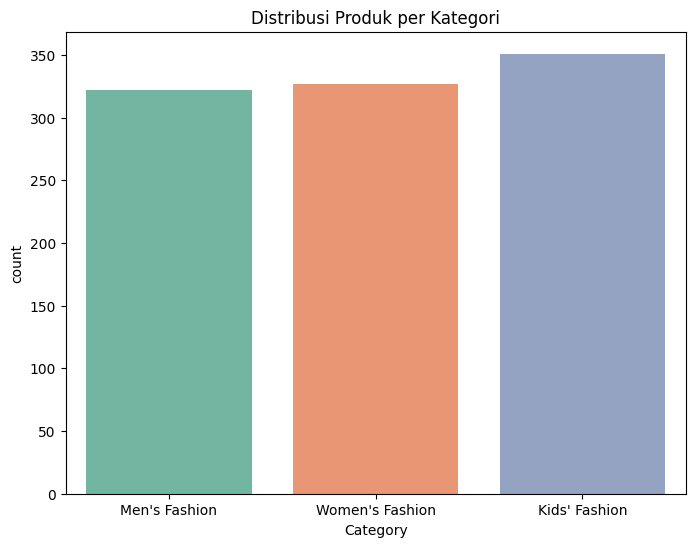

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(data=product_data, x='Category', palette='Set2')
plt.title('Distribusi Produk per Kategori')
plt.show()

Dari visualisasi di atas nampak beberapa informasi di antaranya:
- Secara keseluruhan ketiga kategori produk memiliki jumlah yang mirip.
- Kategori Kid's Fashion memiliki jumlah yang paling unggul disusul oleh Women's Fashion kemudian Men's Fashion.

### Distribusi Produk berdasarkan Brand

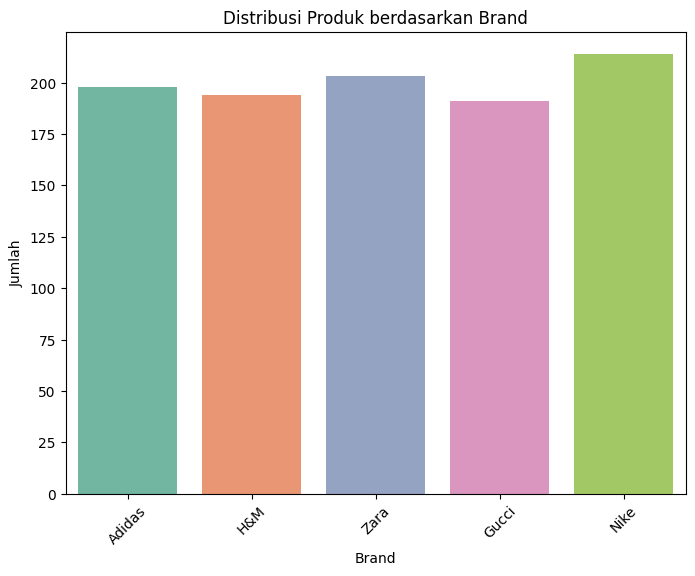

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=product_data, x='Brand', palette='Set2')
plt.title('Distribusi Produk berdasarkan Brand')
plt.xlabel('Brand')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

Dari visualisasi di atas nampak beberapa informasi di antaranya:
- Secara keseluruhan kelima brand memiliki jumlah produk yang tidak terlalu berbeda jauh.
- Brand Nike memiliki jumlah produk yang paling unggul dibandingkan brand yang lain.

### Distribusi Brand dengan Rating Tinggi (4 ke Atas) dan Rating Rendah (2 ke Bawah)

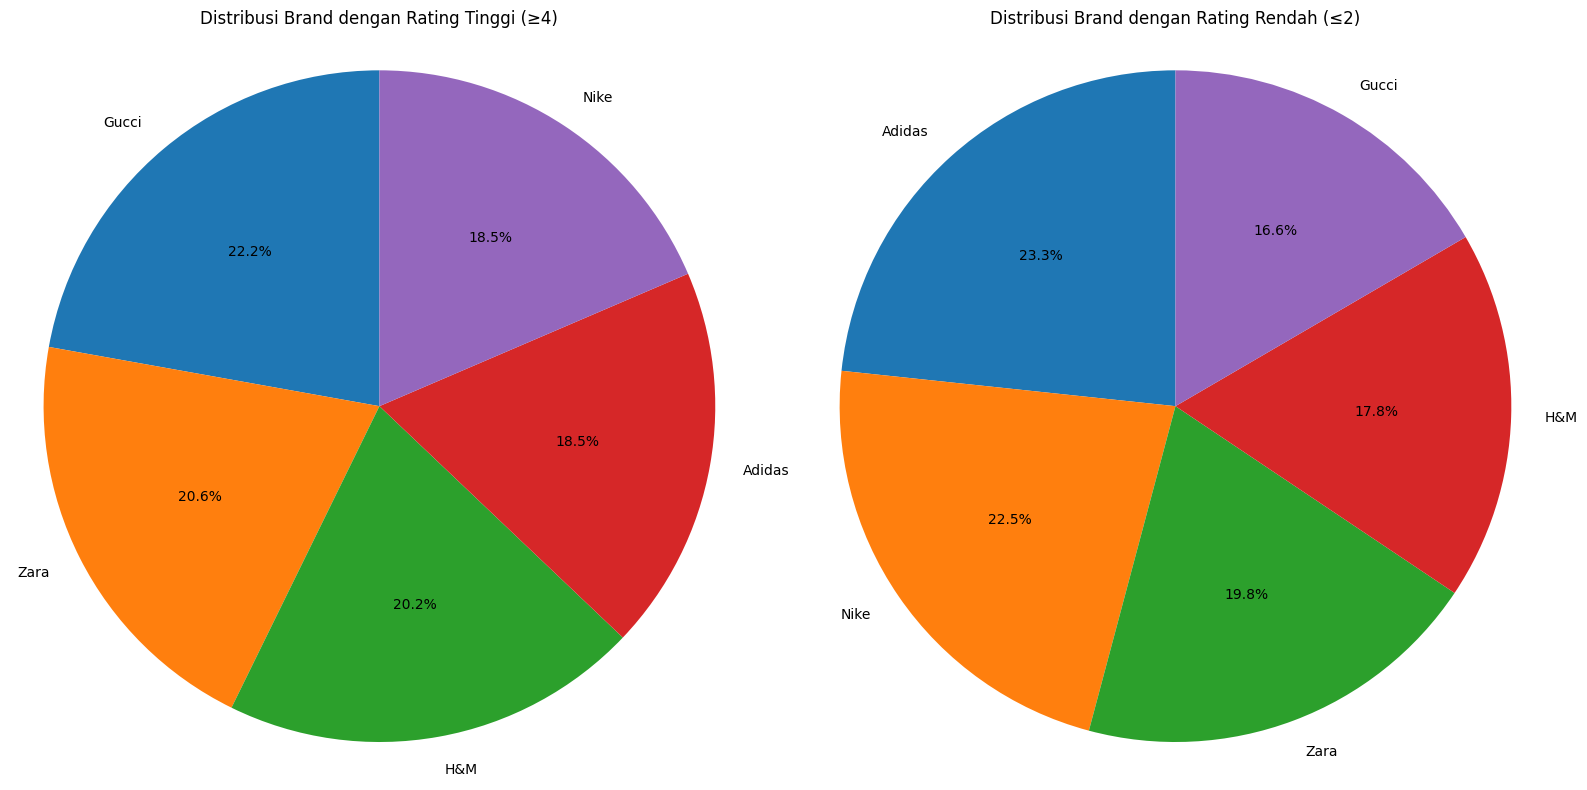

In [9]:
high_rated_products = product_data[product_data['Rating'] >= 4]
high_brand_counts = high_rated_products['Brand'].value_counts()

low_rated_products = product_data[product_data['Rating'] <= 2]
low_brand_counts = low_rated_products['Brand'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].pie(high_brand_counts, labels=high_brand_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribusi Brand dengan Rating Tinggi (≥4)')
axes[0].axis('equal')

axes[1].pie(low_brand_counts, labels=low_brand_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribusi Brand dengan Rating Rendah (≤2)')
axes[1].axis('equal')

plt.tight_layout()
plt.show()


Dari visualisasi di atas didapatkan beberapa informasi antara lain:
- Gucci unggul dalam produk dengan rating yang tinggi dan memiliki jumlah produk dengan rating rendah paling sedikit.
- Sebaliknya, Adidas justru memiliki rating yang rendah terbanyak dan memiliki paling sedikit produk dengan rating tinggi.
- Zara memiliki distribusi yang seimbang antara jumlah produk dengan rating tinggi dan rating yang rendah.

### Korelasi antara Harga dan Rating

           Price    Rating
Price   1.000000  0.033927
Rating  0.033927  1.000000


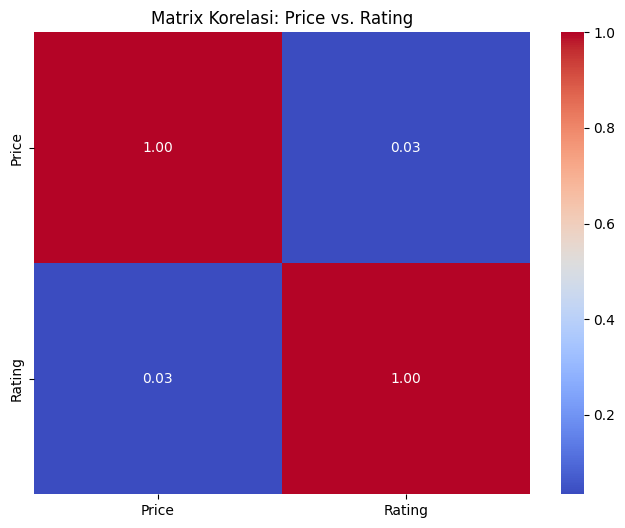

In [10]:
correlation_matrix = product_data[['Price', 'Rating']].corr()

print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrix Korelasi: Price vs. Rating')
plt.show()

Dari visualisasi di atas didapatkan informasi yaitu:
<br>
Korelasi di antara harga dan rating sebesar 0.0339 menunjukkan hubungan yang sangat lemah dan hampir tidak ada antara harga dan rating produk. Artinya, perubahasan harga tidak banyak berpengaruh pada penilaian pengguna.

## 4. Data Preparation

### Preparation untuk Content Based Filtering

#### Menggabungkan Kolom Kategorikal

Proses ini menggabungkan informasi dari beberapa kolom seperti Product Name, Brand, Category, Color, dan Size ke dalam kolom baru bernama description untuk menyediakan representasi teks terpadu dari setiap produk. Data kosong diisi dengan string kosong ('') untuk menghindari error, dan produk dengan deskripsi kosong sepenuhnya dihapus. Tujuannya adalah memastikan setiap produk memiliki deskripsi lengkap untuk analisis lebih lanjut.

In [11]:
product_data['description'] = (
    product_data['Product Name'].fillna('') + " " +
    product_data['Brand'].fillna('') + " " +
    product_data['Category'].fillna('') + " " +
    product_data['Color'].fillna('') + " " +
    product_data['Size'].fillna('')
)

product_data = product_data[product_data['description'].str.strip() != '']


In [12]:
product_data

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size,description
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL,Dress Adidas Men's Fashion Black XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L,Shoes H&M Women's Fashion Black L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL,Dress Adidas Women's Fashion Yellow XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S,Shoes Zara Men's Fashion White S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M,T-shirt Adidas Men's Fashion Black M
...,...,...,...,...,...,...,...,...,...,...
995,20,996,Shoes,Zara,Women's Fashion,55,1.620081,Black,M,Shoes Zara Women's Fashion Black M
996,42,997,Sweater,Nike,Kids' Fashion,13,1.544464,Green,L,Sweater Nike Kids' Fashion Green L
997,9,998,Sweater,Zara,Men's Fashion,47,3.961913,White,L,Sweater Zara Men's Fashion White L
998,8,999,T-shirt,Zara,Women's Fashion,68,3.089722,Blue,S,T-shirt Zara Women's Fashion Blue S


#### Representasi Teks Description dengan TF-IDF

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_data['description'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (1000, 20)


### Preparation for Collaborative Filtering

#### Encoding User ID dan Product ID

In [48]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

product_data['user_encoded'] = user_encoder.fit_transform(product_data['User ID'])
product_data['product_encoded'] = product_encoder.fit_transform(product_data['Product ID'])

print("Jumlah User:", len(user_encoder.classes_))
print("Jumlah Produk:", len(product_encoder.classes_))

Jumlah User: 100
Jumlah Produk: 1000


#### Interaction Matrix

In [49]:
interaction_matrix = product_data.pivot(index='user_encoded', columns='product_encoded', values='Rating').fillna(0)

sparsity = 1 - np.count_nonzero(interaction_matrix) / float(interaction_matrix.size)
print(f"Data sparsity: {sparsity:.4f}")


Data sparsity: 0.9900


#### Split Dataset

In [50]:
X = product_data[['user_encoded', 'product_encoded']].values
y = product_data['Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Train: {X_train.shape}, Data Test: {X_test.shape}")

Data Train: (800, 2), Data Test: (200, 2)


## 5. Modeling with Content Based Filtering

Content Based Filtering adalah metode rekomendasi yang menggunakan informasi atau atribut dari item (misalnya, deskripsi, kategori, atau fitur lainnya) untuk mencocokkan preferensi pengguna. Sistem ini menganalisis fitur item yang sudah disukai pengguna untuk merekomendasikan item serupa.

### Cosine Similarity

In [14]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine Similarity Matrix Shape:", cosine_sim.shape)

Cosine Similarity Matrix Shape: (1000, 1000)


### Mendapatkan Rekomendasi Produk Fashion

In [15]:
def get_product_details(product_id, df):
    product_id = int(product_id)
    idx = df[df['Product ID'] == product_id].index
    if idx.empty:
        raise ValueError(f"Product ID {product_id} tidak ditemukan dalam dataset.")

    input_product = df.iloc[[idx[0]]][['Product ID', 'Product Name', 'Brand', 'Category', 'Color', 'Size']]

    return input_product


def recommend_products(product_id, df, similarity_matrix, top_n=5):
    product_id = int(product_id)
    product_idx = df[df['Product ID'] == product_id].index
    if product_idx.empty:
        raise ValueError(f"Product ID {product_id} tidak ditemukan dalam dataset.")
    product_idx = product_idx[0]

    sim_scores = list(enumerate(similarity_matrix[product_idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]

    product_indices = [i[0] for i in sim_scores]
    recommended_products = df.iloc[product_indices].copy()

    recommended_products = recommended_products[['Product ID', 'Product Name', 'Brand', 'Category', 'Color', 'Size']]
    return recommended_products


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_mse_rmse(predictions, actual_relevance):
    mse = mean_squared_error(actual_relevance, predictions)
    rmse = np.sqrt(mse)

    return mse, rmse

def get_cosine_similarity_scores(product_id, df, similarity_matrix):
    product_id = int(product_id)
    product_idx = df[df['Product ID'] == product_id].index[0]
    sim_scores = similarity_matrix[product_idx]

    return sim_scores

def get_actual_relevance(sim_scores, threshold=0.5):
    return [1 if score >= threshold else 0 for score in sim_scores]


In [17]:
def calculate_mse_rmse_for_all(df, similarity_matrix, top_n=5):
    all_mse = []
    all_rmse = []

    for product_id in df['Product ID'].unique():
        try:
          sim_scores = get_cosine_similarity_scores(product_id, df, similarity_matrix)
          actual_relevance = get_actual_relevance(sim_scores)

          if len(sim_scores) == 0:
              continue

          mse, rmse = calculate_mse_rmse(sim_scores[:top_n], actual_relevance[:top_n]) #consider top_n only
          all_mse.append(mse)
          all_rmse.append(rmse)
        except (ValueError, IndexError) as e:
          print(f"Error processing product ID {product_id}: {e}")
          continue

    return np.mean(all_mse), np.mean(all_rmse)

In [18]:
product_id = 77

input_product = get_product_details(product_id, product_data)
recommended_products = recommend_products(product_id, product_data, cosine_sim)

print("Input Produk")
input_product = input_product.reset_index(drop=True)
display(input_product)

print("\nTop 5 Rekomendasi Produk:")
recommended_products = recommended_products.reset_index(drop=True)
display(recommended_products)

Input Produk


,Product ID,Product Name,Brand,Category,Color,Size
0,77,Sweater,H&M,Kids' Fashion,Blue,L



Top 5 Rekomendasi Produk:


,Product ID,Product Name,Brand,Category,Color,Size
0,687,Sweater,H&M,Kids' Fashion,Blue,L
1,765,Sweater,H&M,Kids' Fashion,Blue,S
2,361,Sweater,H&M,Kids' Fashion,Blue,XL
3,37,Sweater,Zara,Kids' Fashion,Blue,S
4,492,Sweater,Zara,Kids' Fashion,Blue,M


In [19]:
avg_mse, avg_rmse = calculate_mse_rmse_for_all(product_data, cosine_sim)

print(f"Rata-rata MSE pada seluruh produk: {avg_mse:.4f}")
print(f"Rata-rata RMSE pada seluruh produk: {avg_rmse:.4f}")

Rata-rata MSE pada seluruh produk: 0.0711
Rata-rata RMSE pada seluruh produk: 0.2550


## 6. Modeling with Collaborative Filtering

### Model Training

In [89]:
embedding_dim = 100

user_input = layers.Input(shape=(1,), name='user_input')
product_input = layers.Input(shape=(1,), name='product_input')

user_embedding = layers.Embedding(input_dim=len(user_encoder.classes_), output_dim=embedding_dim)(user_input)
product_embedding = layers.Embedding(input_dim=len(product_encoder.classes_), output_dim=embedding_dim)(product_input)

user_embedding = layers.Flatten()(user_embedding)
product_embedding = layers.Flatten()(product_embedding)

user_bias = layers.Embedding(input_dim=len(user_encoder.classes_), output_dim=1, name='user_bias')(user_input)
product_bias = layers.Embedding(input_dim=len(product_encoder.classes_), output_dim=1, name='product_bias')(product_input)

user_bias = layers.Flatten()(user_bias)
product_bias = layers.Flatten()(product_bias)

merged = layers.concatenate([user_embedding, product_embedding])

mlp_layer = layers.Dense(256, activation='relu')(merged)
mlp_layer = layers.Dense(128, activation='relu')(mlp_layer)
mlp_layer = layers.Dense(64, activation='relu')(mlp_layer)
mlp_layer = layers.Dropout(0.2)(mlp_layer)

output = layers.Dense(1, activation='linear')(mlp_layer)
output = layers.add([output, user_bias, product_bias])

model = models.Model(inputs=[user_input, product_input], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 1, 100)         │         10,000 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 100)         │        100,000 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 100)            │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 100)            │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 200)            │              0 │ flatten_12[0][0],      │
│ (Concatenate)             │                        │                │ flatten_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 256)            │         51,456 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │         32,896 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 64)             │          8,256 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_bias (Embedding)     │ (None, 1, 1)           │            100 │ user_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_bias (Embedding)  │ (None, 1, 1)           │          1,000 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1)              │             65 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 1)              │              0 │ user_bias[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 1)              │              0 │ product_bias[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1)              │              0 │ dense_24[0][0],        │
│                           │                        │                │ flatten_14[0][0],      │
│                           │                        │                │ flatten_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 203,773 (795.99 KB)

 Trainable params: 203,773 (795.99 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
history = model.fit([X_train[:, 0], X_train[:, 1]], y_train,
                    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
                    epochs=100, batch_size=64)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.8341 - val_loss: 7.4815
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4502 - val_loss: 1.6836
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7327 - val_loss: 1.6206
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1318 - val_loss: 1.6646
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7987 - val_loss: 1.7141
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3550 - val_loss: 1.7554
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3192 - val_loss: 1.8740
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2536 - val_loss: 1.7602
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2489 - val_loss: 1.7851
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2208 - val_loss: 1.7687
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1924 - val_loss: 1.8036
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

### Mendapatkan Rekomendasi Produk Fashion

In [85]:
def get_user_rated_products(user_id, product_data):
    rated_products = product_data[['User ID', 'Product ID']].drop_duplicates()
    rated_products = rated_products[rated_products['User ID'] == user_id]

    rated_product_details = product_data[product_data['Product ID'].isin(rated_products['Product ID'])]
    rated_product_details = rated_product_details[['Product ID', 'Product Name', 'Brand', 'Category', 'Price', 'Rating']]

    rated_product_details = rated_product_details.sort_values(by='Rating', ascending=False)
    rated_product_details = rated_product_details.reset_index(drop=True)

    return rated_product_details

In [104]:
def get_recommendations(user_id, product_data, model, product_encoder, top_n=5):
    user_encoded = user_encoder.transform([user_id])[0]
    product_ids = np.arange(len(product_encoder.classes_))

    user_product_combinations = np.array([[user_encoded, pid] for pid in product_ids])
    predictions = model.predict([user_product_combinations[:, 0], user_product_combinations[:, 1]])

    predicted_ratings_df = pd.DataFrame({
        'product_encoded': product_ids,
        'predicted_rating': predictions.flatten()
    })

    rated_products = product_data[product_data['User ID'] == user_id]['product_encoded']
    predicted_ratings_df = predicted_ratings_df[~predicted_ratings_df['product_encoded'].isin(rated_products)]

    recommended = predicted_ratings_df.nlargest(top_n, 'predicted_rating')
    recommended_products = product_data[product_data['product_encoded'].isin(recommended['product_encoded'])]

    return recommended_products[['Product ID', 'Product Name', 'Brand', 'Category', 'Price', 'Rating']]


In [105]:
user_id = 98
top_n = 5

rated_products = get_user_rated_products(user_id, product_data)
print(f"Produk yang telah diberi rating oleh User ID {user_id}:")
display(rated_products)

recommended_products = get_recommendations(user_id, product_data, model, product_encoder, top_n)
print(f"Top {top_n} rekomendasi untuk User ID {user_id}:")
display(recommended_products)


Produk yang telah diberi rating oleh User ID 98:


,Product ID,Product Name,Brand,Category,Price,Rating
0,29,Shoes,Gucci,Women's Fashion,85,4.940985
1,898,Dress,Nike,Women's Fashion,44,4.210620
2,779,Jeans,Nike,Kids' Fashion,94,3.726036
3,32,T-shirt,Nike,Kids' Fashion,78,3.447289
4,173,Dress,Nike,Kids' Fashion,21,3.101799
5,50,T-shirt,H&M,Women's Fashion,38,3.083286
6,73,T-shirt,Gucci,Men's Fashion,34,2.923982
7,528,Shoes,Zara,Men's Fashion,33,2.714762
8,934,T-shirt,Nike,Women's Fashion,82,2.636832
9,893,Shoes,H&M,Kids' Fashion,76,2.072748


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top 5 rekomendasi untuk User ID 98:


,Product ID,Product Name,Brand,Category,Price,Rating
32,33,Jeans,H&M,Kids' Fashion,89,4.799409
301,302,T-shirt,Gucci,Kids' Fashion,37,4.903872
615,616,Dress,Zara,Women's Fashion,98,4.871839
701,702,Shoes,Gucci,Kids' Fashion,58,4.794782
703,704,T-shirt,Adidas,Kids' Fashion,38,4.979678


## 7. Model Evaluation

Seperti yang telah dijelaskan sebelumnya, metrik evaluasi yang digunakan adalah Mean Square Error (MAE) dan Root Mean Square Error (RMSE). Kedua metrik tersebut dipilih karena keduanya memberikan ukuran yang jelas tentang sejauh mana prediksi rating atau preferensi produk yang diberikan oleh model menyimpang dari rating atau preferensi asli pengguna.

- Mean Squared Error (MSE)
  MSE menghitung rata-rata kuadrat dari selisih antara nilai prediksi dan nilai aktual.
  Dengan mengkuadratkan selisih, MSE memberikan bobot yang lebih besar pada kesalahan yang besar. Ini berarti bahwa model akan lebih "dihukum" jika membuat prediksi yang jauh dari nilai sebenarnya.
    
  MSE sering digunakan ketika kita ingin memberikan penalti yang lebih besar pada kesalahan yang besar, karena kesalahan yang besar dapat memiliki konsekuensi yang lebih signifikan.
    
  \begin{equation}
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  \end{equation}
      
  Di mana:
  \begin{aligned}
      \text{MSE} & = \text{Mean Squared Error} \\
      n & = \text{Jumlah data observasi} \\
      y_i & = \text{Nilai aktual ke-} i \\
      \hat{y}_i & = \text{Nilai prediksi ke-} i
  \end{aligned}

- Root Mean Squared Error (RMSE)
  RMSE (Root Mean Squared Error) adalah akar kuadrat dari MSE, yang memberikan ukuran rata-rata kesalahan prediksi dalam satuan yang sama dengan data asli.

  RMSE mempertahankan sifat MSE yang memberikan penalti lebih besar pada kesalahan besar, namun dengan membuat hasilnya lebih mudah dipahami karena mengembalikan kesalahan ke skala yang lebih mudah diinterpretasikan. RMSE sering digunakan ketika kita ingin menilai akurasi model dengan mempertimbangkan besarnya kesalahan dalam konteks yang lebih terukur dan dapat dibandingkan langsung dengan data aslinya.

  \begin{equation}
    \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( r_{i} - \hat{r}_{i} \right)^2}
  \end{equation}
    
  Di mana:
  \begin{aligned}
        \text{RMSE} & = \text{Root Mean Squared Error, metrik untuk mengukur kesalahan prediksi model.} \\
        r_{i} & = \text{Nilai aktual untuk item ke-i, misalnya rating asli yang diberikan oleh pengguna.} \\
        \hat{r}_{i} & = \text{Prediksi untuk item ke-i yang dihasilkan oleh model.} \\
        N & = \text{Jumlah total sampel (data) yang digunakan dalam evaluasi.}
  \end{aligned}

### Perbandingan Performa Content Based Filtering dan Collaborative Filtering

In [28]:
avg_mse, avg_rmse = calculate_mse_rmse_for_all(product_data, cosine_sim)
y_pred = model.predict([X_test[:, 0], X_test[:, 1]])
mse = mean_squared_error(y_test, y_pred)

print("Evaluasi Content Based Filtering")
print(f"Rata-rata MSE pada seluruh produk: {avg_mse:.4f}")
print(f"Rata-rata RMSE pada seluruh produk: {avg_rmse:.4f}")

print("\nEvaluasi Collaborative Filtering")
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.4f}')

rmse = math.sqrt(mse)
print(f'RMSE: {rmse:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluasi Content Based Filtering
Rata-rata MSE pada seluruh produk: 0.0711
Rata-rata RMSE pada seluruh produk: 0.2550

Evaluasi Collaborative Filtering
MSE: 1.7791
RMSE: 1.3338


Berdasarkan hasil evaluasi menggunakan MSE dan RMSE, sistem Content Based Filtering dengan menggunakan Cosine Similarity menunjukkan performa yang cukup baik dalam merekomendasikan produk yang relevan. Dengan rata-rata MSE sebesar 0.0711 dan RMSE sebesar 0.2550, sistem berhasil meminimalkan kesalahan prediksi, menunjukkan bahwa produk yang direkomendasikan memiliki tingkat relevansi yang cukup tinggi terhadap preferensi pengguna. Threshold similarity 0.5 yang diterapkan memastikan bahwa hanya produk dengan kemiripan yang signifikan yang dipertimbangkan, menjaga kualitas rekomendasi dan relevansi hasil yang diberikan.

Sedangkan pada metode NCF, MSE sebesar 1.7791 dan RMSE sebesar 1.3338 menunjukkan bahwa model memiliki akurasi yang cukup baik dalam memprediksi rating untuk produk yang belum dinilai oleh pengguna. Meskipun nilai MSE dan RMSE menunjukkan adanya ruang untuk perbaikan, model ini berhasil memanfaatkan pola perilaku rating pengguna sebelumnya untuk memberikan rekomendasi produk yang relevan. Ke depannya, improvisasi dapat dilakukan dengan memperbaiki arsitektur model, menambahkan fitur baru, atau menggunakan teknik regularisasi untuk mengurangi overfitting dan meningkatkan akurasi prediksi.